In [49]:
import random

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import h3pandas
import cupy
# from dask.distributed import Client

# cluster = LocalCUDACluster()
# client = Client(cluster)
import sklearn.cluster

In [50]:
nypd_data = pd.read_csv('../../data/clean/police_data/NYPDcleanupfinal.csv')

In [51]:
# def plot_elbow(kmean, X):
#     centroids = [k.cluster_centers_ for k in kmean]
#     D_k = [cdist(X, center, 'euclidean') for center in centroids]
#     dist = [np.min(D, axis=1) for D in D_k]
#
#     # Total with-in sum of square
#     wcss = [sum(d ** 2) for d in dist]
#     tss = sum(pdist(X) ** 2) / X.shape[0]
#     bss = tss - wcss
#
#     plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
#     ax = plt.subplot(1, 1, 1)
#     ax.plot(Ks, bss / tss * 100, 'b*-')
#     plt.grid(True)
#     plt.xlabel('Number of clusters')
#     plt.ylabel('Percentage of variance explained (%)')
#     plt.title('Elbow for KMeans clustering')
#     plt.show()

In [63]:
sales_data = pd.read_csv('../../data/clean/SalesFinal.csv')

In [79]:
building_data = gpd.read_file('../../data/clean/building_stats.csv')
park_mask = gpd.read_file('../../data/clean/park_hexes.csv')
building_data = building_data.set_index('hex_id')
park_mask = park_mask.set_index('hex_id')

In [65]:
hex_files = ('bronx_hex.csv', 'brooklyn_hex.csv', 'manhattan_hex.csv', 'queens_hex.csv', 'staten_hex.csv')
hex_dfs = []
for f in hex_files:
    hex_dfs = hex_dfs + list(pd.read_csv(f"../../data/clean/h3_index/{f}")[f.split('.')[0]])


In [66]:
# hex_dfs

In [67]:
nypd_data = nypd_data[nypd_data['h3geo'].isin(hex_dfs)]
nypd_data['RPT_DT'] = pd.to_datetime(nypd_data['RPT_DT'])
# nypd_data = nypd_data[nypd_data['RPT_DT'].dt.year == 2021]

In [68]:
sales_data = sales_data[sales_data['h3geo'].isin(hex_dfs)]
sales_data['BUILDING_CLASS'] = sales_data['BUILDING CLASS AT TIME OF SALE']

selected_cols_sales = sales_data[[
    'h3geo',
    'BUILDING_CLASS',
    'YEAR BUILT',
    'SALE PRICE'
    ]]

In [69]:
clean_nypd = nypd_data.set_index('h3geo')
clean_nypd['lat'] = clean_nypd['Latitude']
clean_nypd['lon'] = clean_nypd['Longitude']
clean_nypd = clean_nypd.drop(['Latitude', 'Longitude'], axis=1)

In [70]:
selected_cols_nypd = clean_nypd[[
    'CMPLNT_FR_TM',
    'RPT_DT',
    'KY_CD',
    'OFNS_DESC',
    'CRM_ATPT_CPTD_CD',
    'LAW_CAT_CD',
    'JURIS_DESC',
    ]]
selected_cols_nypd = selected_cols_nypd[selected_cols_nypd['OFNS_DESC'].isnull() == False]


In [71]:
def get_hour_of_day(thetime):
    strips = thetime.split(':')
    hour = int(strips[0])
    if hour < 5:
        return 'NIGHT'
    elif hour < 11:
        return 'MORNING'
    elif hour < 17:
        return 'DAY'
    elif hour < 23:
        return 'EVENING'
    else:
        return 'NIGHT'


In [72]:
# selected_cols_nypd['FUZZY_TIME'] = selected_cols_nypd['CMPLNT_FR_TM'].apply(get_hour_of_day)
selected_cols_nypd = selected_cols_nypd.drop(['CMPLNT_FR_TM', 'RPT_DT'], axis=1)

In [73]:
nypd_fe = pd.get_dummies(selected_cols_nypd,
                         # columns=['OFNS_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'JURIS_DESC', 'KY_CD', 'FUZZY_TIME'],
                         columns=['OFNS_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'JURIS_DESC', 'KY_CD'],
                         prefix_sep='_')


In [74]:
nypd_fe = nypd_fe.groupby('h3geo').sum()

In [62]:
selected_cols_sales['BUILDING_CLASS'] = selected_cols_sales['BUILDING_CLASS'].apply(lambda x: x[0])

/tmp/ipykernel_809068/2716758635.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_cols_sales['BUILDING_CLASS'] = selected_cols_sales['BUILDING_CLASS'].apply(lambda x: x[0])


In [16]:
sales_fe = pd.get_dummies(selected_cols_sales, columns=['BUILDING_CLASS']).set_index('h3geo')
sales_fe['COUNT'] = 1
sales_fe2 = sales_fe.groupby('h3geo').sum()
sales_fe = sales_fe.groupby('h3geo').sum()
sales_fe['MEAN_BLD_AGE'] = 2023 - (sales_fe['YEAR BUILT'] / sales_fe['COUNT'])
sales_fe['MEAN_SALE_PRICE'] = sales_fe['SALE PRICE'] / sales_fe['COUNT']

In [17]:
sales_fe3 = sales_fe2.div(sales_fe2['COUNT'], axis=0)
sales_fe2 = sales_fe2.drop(['YEAR BUILT', 'SALE PRICE', 'COUNT'], axis=1)

# sales_fe2

In [18]:
sales_fe = sales_fe.drop(['YEAR BUILT', 'SALE PRICE'], axis=1)

In [19]:
sales_fe = sales_fe[['COUNT', 'MEAN_BLD_AGE', 'MEAN_SALE_PRICE']]
sales_fe = sales_fe.join(sales_fe2)

In [236]:
helper_outer = sales_fe.join(nypd_fe, how='outer').join(building_data, how='outer')
helper_inner = sales_fe.join(nypd_fe, how='inner')
helper_inner = nypd_fe

wopt = pd.DataFrame(hex_dfs, columns=['hex_id'])
wopt = wopt.set_index('hex_id')
all_hexes = wopt.join(helper_outer, how='inner')
all_hexes.shape
wopt

""
hex_id
8a2a100a894ffff
8a2a100a1d47fff
8a2a10010aa7fff
8a2a1001355ffff
8a2a100f6507fff
...
8a2a1062bcc7fff
8a2a10608cc7fff
8a2a1062e687fff


In [230]:
helper_all = pd.DataFrame(hex_dfs, columns=['h3geo']).set_index('h3geo')
police_all = helper_all.join(nypd_fe, how='inner')

In [231]:
helper = pd.read_csv('../../data/clean/h3_index/brooklyn_hex.csv')
helper.columns = ['h3geo']
helper = helper.set_index('h3geo')
# helper = helper.join(sales_fe, how='left')

In [232]:
# helper = helper.join(nypd_fe, how='left')

In [81]:
# helper_outer = helper_outer_nonan =

,COUNT,MEAN_BLD_AGE,MEAN_SALE_PRICE,BUILDING_CLASS_A,BUILDING_CLASS_B,BUILDING_CLASS_C,BUILDING_CLASS_D,BUILDING_CLASS_E,BUILDING_CLASS_F,BUILDING_CLASS_G,...,KY_CD_578,KY_CD_672,KY_CD_675,KY_CD_676,KY_CD_677,KY_CD_678,KY_CD_685,KY_CD_881,BldgArea,BldgAge
8a2a10000287fff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4456,75.5
8a2a1000028ffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,596,90.5
8a2a10000297fff,1.0,78.0,7.600000e+05,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41770,160.2608695652175
8a2a1000029ffff,1.0,37.0,6.350000e+05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20394,215.0
8a2a100002b7fff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19656,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8a2a10776d6ffff,3.0,124.0,1.533333e+06,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86838,211.66666666666674
8a2a10776d77fff,4.0,78.0,2.381000e+06,0.0,2.0,1.0,0.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130337,426.9000000000001
8a2a10776d87fff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111265,103.0
8a2a10776da7fff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79000,64.5


In [24]:
import geopandas
import h3pandas



In [82]:
import folium
from libpysal.weights import Queen, KNN
from esda.moran import Moran
import seaborn
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import haversine_distances

from sklearn.cluster import KMeans

In [26]:
cluster_variables = ['BldgArea', 'YearBuilt', 'AssessTot', 'ResArea'

                     ]

In [29]:
helper

""
h3geo
8a2a100de247fff
8a2a1074616ffff
8a2a100d8d57fff
8a2a10741c0ffff
8a2a100d1367fff
...
8a2a1039034ffff
8a2a100cb4dffff
8a2a100d0277fff


In [4]:
# #1.1 data preparation
# X = helper_inner.iloc[:, 1:].values
# # Using the elbow method to find the optimal number of clusters
# wcss = []
# for i in range(1, 60):
#     kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
#     kmeans.fit(X)
#     wcss.append(kmeans.inertia_)
# plt.plot(range(1, 60), wcss)
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()

NameError: name 'helper_inner' is not defined

In [27]:
df_map = helper_all.join(helper_inner, how='left').fillna(method='ffill')
# df_map = helper.join(helper_inner, how='inner')
# df_map = helper_inner
w = Queen.from_dataframe(df_map.h3.h3_to_geo_boundary().reset_index())

clean = df_map.h3.h3_to_geo_boundary().reset_index().drop(w.islands)
w2 = Queen.from_dataframe(clean)
w = w2
w2

/home/thowe/anaconda3/envs/plz-gpu/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 69 disconnected components.
 There are 26 islands with ids: 63, 2687, 5449, 6231, 9059, 9270, 10704, 11476, 12443, 13512, 13696, 14908, 17416, 17563, 18505, 18787, 19992, 21093, 21239, 21647, 28309, 34185, 35143, 39846, 48409, 50294.
  warnings.warn(message)
/home/thowe/anaconda3/envs/plz-gpu/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 43 disconnected components.
  warnings.warn(message)


In [28]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import robust_scale

# db_scaled = robust_scale(clean.set_index('h3geo').drop(['COUNT', 'geometry'], axis=1))
db_scaled = robust_scale(clean.set_index('h3geo').drop(['geometry'], axis=1))

# # Set the seed for reproducibility
# np.random.seed(123456)
# # Specify cluster model with spatial constraint
# model = AgglomerativeClustering(
#     linkage='average', connectivity=w.sparse, n_clusters=5, compute_full_tree=True
#     )
# # Fit algorithm to the data
# model.fit(db_scaled)

In [29]:
clean['ward5wq'] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(30, 30))
# Plot unique values choropleth including a legend and with no boundary lines
clean.plot(column='ward5wq', legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

NameError: name 'model' is not defined

In [30]:
clean

,h3geo,OFNS_DESC_ABORTION,OFNS_DESC_ADMINISTRATIVE CODE,OFNS_DESC_ADMINISTRATIVE CODES,OFNS_DESC_AGRICULTURE & MRKTS LAW-UNCLASSIFIED,OFNS_DESC_ALCOHOLIC BEVERAGE CONTROL LAW,OFNS_DESC_ANTICIPATORY OFFENSES,OFNS_DESC_ARSON,OFNS_DESC_ASSAULT 3 & RELATED OFFENSES,OFNS_DESC_BURGLAR'S TOOLS,...,KY_CD_577,KY_CD_578,KY_CD_672,KY_CD_675,KY_CD_676,KY_CD_677,KY_CD_678,KY_CD_685,KY_CD_881,geometry
0,8a2a100a894ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.90294 40.84156, -73.90385 40.841..."
1,8a2a100a1d47fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.91549 40.88208, -73.91641 40.881..."
2,8a2a10010aa7fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.84959 40.87396, -73.85051 40.873..."
3,8a2a1001355ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.87936 40.85844, -73.88028 40.858..."
4,8a2a100f6507fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-73.92331 40.80512, -73.92422 40.804..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51715,8a2a1062bcc7fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-74.13358 40.55895, -74.13448 40.558..."
51716,8a2a10608cc7fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-74.17749 40.53923, -74.17840 40.539..."
51717,8a2a1062e687fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-74.14321 40.58506, -74.14412 40.584..."
51718,8a2a1060ed07fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-74.18917 40.56263, -74.19007 40.562..."


In [31]:
clean[, 2:]

SyntaxError: invalid syntax (4055502895.py, line 1)

In [32]:
# import plotly.express as px
# import plotly.graph_objects as go

plt.rcParams['figure.figsize'] = (12, 8)
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import StandardScaler

In [106]:
db_scaled = robust_scale(all_hexes)
all_hexes

,COUNT,MEAN_BLD_AGE,MEAN_SALE_PRICE,BUILDING_CLASS_A,BUILDING_CLASS_B,BUILDING_CLASS_C,BUILDING_CLASS_D,BUILDING_CLASS_E,BUILDING_CLASS_F,BUILDING_CLASS_G,...,KY_CD_578,KY_CD_672,KY_CD_675,KY_CD_676,KY_CD_677,KY_CD_678,KY_CD_685,KY_CD_881,BldgArea,BldgAge
8a2a100a894ffff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55071,73.59999999999991
8a2a100a1d47fff,1.0,2.000000,2.275000e+06,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,279923,65.28571428571422
8a2a10010aa7fff,5.0,76.000000,4.704000e+05,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92866,76.40425531914889
8a2a100f6507fff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
8a2a1001dd9ffff,1.0,73.000000,6.450000e+05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72867,73.44186046511618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8a2a10752817fff,3.0,26.333333,5.036667e+05,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57210,103.62745098039227
8a2a10608387fff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19936,63.0
8a2a1062bcc7fff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31272,53.0
8a2a10608cc7fff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41652,58.0


In [34]:
db = DBSCAN(eps=0.5, min_samples=6)

In [35]:
db_p = db.fit_predict(db_scaled)
helper

""
h3geo
8a2a100de247fff
8a2a1074616ffff
8a2a100d8d57fff
8a2a10741c0ffff
8a2a100d1367fff
...
8a2a1039034ffff
8a2a100cb4dffff
8a2a100d0277fff


In [36]:
dew_it = pd.DataFrame(db_p).set_index(police_all.index)
dew_it

,0
h3geo,
8a2a100a894ffff,-1
8a2a100a1d47fff,-1
8a2a10010aa7fff,-1
8a2a100f6507fff,-1
8a2a1001dd9ffff,-1
...,...
8a2a1062ab37fff,-1
8a2a106e62b7fff,0
8a2a10752817fff,-1


In [37]:
import hdbscan

In [38]:
db_scaled_copy = db_scaled.copy()
db_scaled_copy = pd.DataFrame(db_scaled_copy)
db_scaled_copy = db_scaled_copy.set_index(police_all.index)
db_scaled_copy.columns = police_all.columns
db_scaled_copy['Cluster'] = db_p
# final = db_scaled_copy.groupby('Cluster').mean()
# # final = final.transpose().reset_index()

In [39]:
db_scaled_copy

,OFNS_DESC_ABORTION,OFNS_DESC_ADMINISTRATIVE CODE,OFNS_DESC_ADMINISTRATIVE CODES,OFNS_DESC_AGRICULTURE & MRKTS LAW-UNCLASSIFIED,OFNS_DESC_ALCOHOLIC BEVERAGE CONTROL LAW,OFNS_DESC_ANTICIPATORY OFFENSES,OFNS_DESC_ARSON,OFNS_DESC_ASSAULT 3 & RELATED OFFENSES,OFNS_DESC_BURGLAR'S TOOLS,OFNS_DESC_BURGLARY,...,KY_CD_577,KY_CD_578,KY_CD_672,KY_CD_675,KY_CD_676,KY_CD_677,KY_CD_678,KY_CD_685,KY_CD_881,Cluster
h3geo,,,,,,,,,,,,,,,,,,,,,
8a2a100a894ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.227273,0.0,-0.250,...,0.0,-0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
8a2a100a1d47fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.227273,0.0,0.250,...,0.0,0.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
8a2a10010aa7fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.090909,0.0,0.125,...,0.0,-0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
8a2a100f6507fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.227273,0.0,-0.500,...,0.0,-0.428571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
8a2a1001dd9ffff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.409091,0.0,0.500,...,0.0,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8a2a1062ab37fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.318182,0.0,-0.375,...,0.0,-0.357143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
8a2a106e62b7fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.318182,0.0,-0.500,...,0.0,-0.392857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8a2a10752817fff,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,-0.375,...,0.0,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


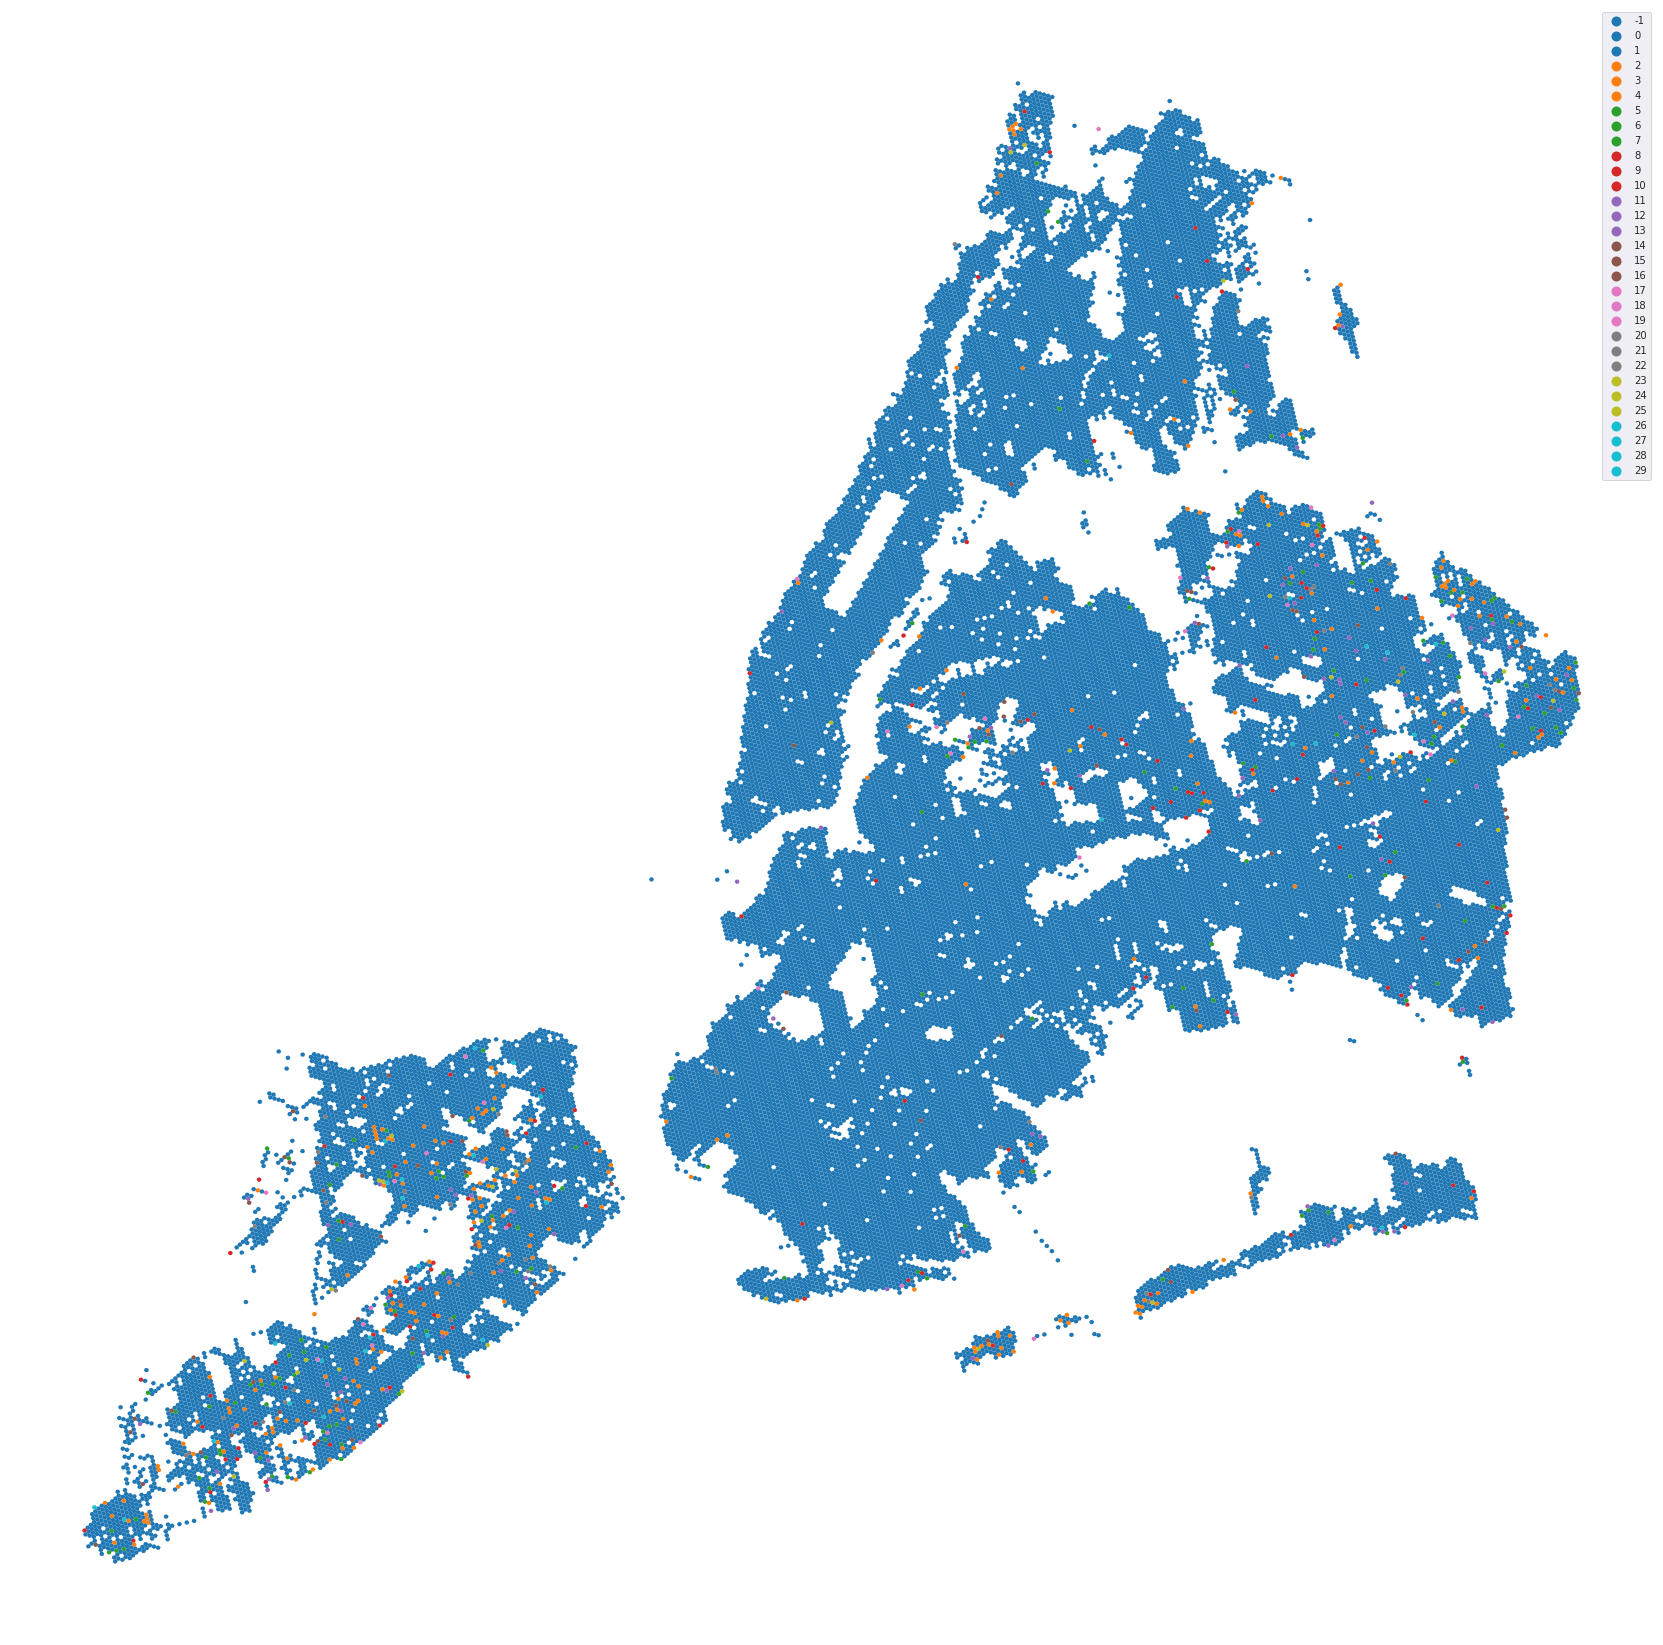

In [503]:
db_scaled_copy = db_scaled_copy.h3.h3_to_geo_boundary()
db_scaled_copy.index.names = ['hex_id']

db_scaled_copy_2 = mask(db_scaled_copy.reset_index(), the_mask)
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(30, 30))
# Plot unique values choropleth including a legend and with no boundary lines
db_scaled_copy_2.plot(column='Cluster', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [41]:
from sklearn.decomposition import PCA

In [42]:
PCA(db_scaled).score()
db_scaled.shape

(36907, 175)

In [406]:
neighborhood_centroids = pd.read_csv('../../data/clean/neighborhood_centroids.csv')
from h3 import h3_distance
import h3
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import nan_euclidean_distances

_, cell_len = db_scaled.shape
cell_dict = {}


class CellFactory:

    def __init__(self, hex_list, data_list, neighborhood_id_list):

        self.hex_list = hex_list
        self.data_list = data_list
        self.neighborhood_id_list = neighborhood_id_list.set_index('hex_id')
        # print(len(self.neighborhood_id_list))

        self.cell_dict = {}
        self.neighborhood_list = []

    def generate_cells(self, all_cells=False):
        if all_cells:
            index_list = self.hex_list.join(self.data_list, how="left", lsuffix='L')
        else:
            index_list = self.hex_list.join(self.data_list, how="inner", lsuffix='L')

        # self.neighborhood_id_list = self.neighborhood_id_list.filter(items=index_list['hex_id'], axis=0).filter(i)

        for index, row in index_list.iterrows():
            hex_id = row['hex_id']
            #TODO: DON"T HARD CODE THIS, ITS BAD.  Set the correct pre and post conditions for the data dfs!!
            self.cell_dict[hex_id] = HexCell(hex_id, self, data_values=list(row[2:]))

        self.trim_neighbors()

    def generate_neighborhoods(self):
        self.neighborhood_list = []
        for hood_id, hood_name in self.neighborhood_id_list.iterrows():
            print(hood_id)
            # if hood_id in self.cell_dict.keys():
            self.neighborhood_list += [GreedyNeighborhood(self.cell_dict[hood_id], hood_name[0], factory=self)]

    def get_cell_dict(self):
        return self.cell_dict

    def trim_neighbors(self):
        for key in self.cell_dict.keys():
            self.cell_dict[key].neighbor_ids = [the_id for the_id in self.cell_dict[key].neighbor_ids if
                                                the_id in self.cell_dict.keys()]

    def simulate(self, n=2):
        new_hood_list = []
        for i in range(1, n + 1):

            for hood in self.neighborhood_list:
                print(f"Simulating round {i} of {n}")
                print(f"Current Neighborhood: {hood.get_name()}")
                hood.play_turn()
                clear_output(wait=True)
                new_hood_list = new_hood_list + [hood.update_factory()]

        self.neighborhood_list = new_hood_list

    def get_results(self):
        results_list = []
        for hood in self.neighborhood_list:
            # print(hood.output_cell_map())
            results_list = results_list + [hood.output_cell_map()]

        output = pd.concat(results_list)
        return output

    def plot_neighborhoods(self):
        pass

    def do_it_myself(self):
        df = pd.DataFrame()
        for key, cell in self.cell_dict.items():
            df[key] = cell.neighborhood_id

        return df


In [407]:
import random


class HexCell:
    """

    """

    def __init__(self, hex_id, factory, data_values=([None] * cell_len)):
        self.hex_id = hex_id
        self.neighbor_ids = list(h3.k_ring(hex_id))
        self.data_values = data_values
        self.affinity = -1
        self.neighborhood_id = -1
        self.oob = True
        self.factory = factory

    def set_data_values(self, data_values, start_index=0, end_index=cell_len):
        self.data_values = data_values

    # def __copy__(self):
    #     return copy.copy(self)

    def get_data_values(self, fill_nan):
        if fill_nan:
            newvals = []
            for val in self.data_values:
                if pd.isna(val):
                    newvals = newvals + [random.uniform(0, 1)]
                else:
                    newvals = newvals + [val]
            return newvals
        else:
            return self.data_values

    def detect_border(self):
        for id in self.neighbor_ids:
            if self.factory.cell_dict[id].neighborhood_id != self.neighborhood_id:
                return True

        # for id in self.neighbor_ids:
        #           if id in self.factory.cell_dict.keys():
        #               if self.factory.cell_dict[id].neighborhood_id != self.neighborhood_id:
        #                   return True

        return False





In [483]:
from copy import copy


class GreedyNeighborhood:
    """

    """

    def __init__(self, starting_cell, name, factory):
        self.centroid_cell = copy(starting_cell)
        self.centroid_id = self.centroid_cell.hex_id
        self.centroid_cell.neighborhood_id = self.centroid_id

        self.name = name
        self.neighborhood_mean = (self.centroid_cell.get_data_values(True))

        self.factory = factory
        self.factory.cell_dict[self.centroid_id] = self.centroid_cell

        ## initializing lists of cells that are part of the neighborhood
        self.border_cells = [self.centroid_id]
        self.interior_cells = [self.centroid_id]
        self.wanted_cells = []

        # print (self.centroid_cell.neighbor_ids)

    def play_turn(self):
        self.get_wanted_neighbors()
        if len(self.wanted_cells):
            self.claim_cells()

    def resolve_ownership_disputes(self):
        self.add_to_interior([cell for cell in self.get_owned_cells() if
                              self.factory.cell_dict[cell].neighborhood_id == self.centroid_id])

    # gets a list of all neighbors of bordering cells  and then trims any that are already in the neighborhood be
    def get_wanted_neighbors(self):
        for cell_id in self.border_cells:
            cell = self.factory.cell_dict[cell_id]
            potentials = cell.neighbor_ids
            potentials = np.setdiff1d(potentials, self.get_owned_cells())
            # print(potentials)
            # print(self.wanted_cells)
            self.wanted_cells = list(self.wanted_cells) + list(potentials)
            self.wanted_cells = list(set(self.wanted_cells))

    def get_owned_cells(self):
        return self.border_cells + self.interior_cells

    def is_connected(self):
        pass

    def get_distance(self, X, Y, Y_norm_sqd):
        return euclidean_distances(X, Y, Y_norm_squared=Y_norm_sqd, squared=True)

    def get_nan_distance(self, X, Y):
        return nan_euclidean_distances(X, Y, squared=True)

    def claim_cells(self):
        self.neighborhood_mean = self.recompute_mean()
        Y = np.array(self.neighborhood_mean).reshape(1, -1)
        X = np.array([self.factory.cell_dict[cell].get_data_values(True) for cell in self.wanted_cells]).reshape(
            len(self.wanted_cells), -1)
        # X = np.array([self.factory.cell_dict[cell].get_data_values() for cell in self.wanted_cells]).reshape(-1,1)
        # print(f"X.shape, X= {X.shape} , {X}")
        # print(f"Y.shape, y = {(Y.shape)} , {Y}")
        # X = np.array([print(cell) for cell in self.wanted_cells]).reshape(-1,1)

        rez = pd.DataFrame(nan_euclidean_distances(X, Y, squared=True), columns=['dist'])
        # rez = pd.DataFrame(euclidean_distances(X, Y, squared=True), columns=['dist'])

        # Y_norm_sqd = int(np.exp2(Y).sum())
        # rez = pd.DataFrame(euclidean_distances(X, Y, Y_norm_squared=Y_norm_sqd, squared=True), columns=['dist'])

        rez['current_affinity'] = [self.factory.cell_dict[cell].affinity for cell in self.wanted_cells]
        rez['delta_affinity'] = rez['dist'] - rez['current_affinity']
        rez['id'] = self.wanted_cells
        temp = rez[(rez['delta_affinity'] > 0)]

        # print(rez[(rez['delta_affinity'] > 0)])
        claiming_cells = temp['id']
        for _, row in temp.iterrows():
            self.factory.cell_dict[row['id']].affinity = row['dist']
            self.factory.cell_dict[row['id']].neighborhood_id = self.centroid_id

        self.wanted_cells = np.setdiff1d(self.wanted_cells, claiming_cells)
        # self.border_cells = self.border_cells + list(claiming_cells)
        """
        TODO FIX THIS GARBANZO BEANS
        """
        # new_border = [self.factory.cell_dict[cell].detect_border() for cell in self.border_cells]
        # print(new_border)
        # # self.border_cells = self.border_cells[new_border]
        # self.interior_cells += self.interior_cells[new_border == False]

        self.add_to_interior(claiming_cells)

    def determine_border(self):
        new_border = []
        for cell_id in self.border_cells:
            if self.factory.cell_dict[cell_id].neighborhood_id == self.centroid_id:
                new_border = new_border + [cell_id]

    def add_to_interior(self, new_cell_ids):
        check_list = []
        for cell_id in new_cell_ids:
            check_list = check_list + self.factory.cell_dict[cell_id].neighbor_ids

        # check_list  = [x for x in check_list if x in self.factory.cell_dict.keys()]

        to_interior_list = []
        for cell_id in check_list:
            cell = self.factory.cell_dict[cell_id]
            if cell.neighborhood_id == self.centroid_id:
                if not cell.detect_border():
                    to_interior_list = to_interior_list + [cell_id]
                else:
                    self.border_cells = self.border_cells + [cell_id]

        self.interior_cells = list(set(self.interior_cells + to_interior_list))
        self.border_cells = list(set(self.border_cells))

        # TODO: HANDLE BORDER INCURSIONS

    def pick_me(self, neighbor):
        pass

    def agree_on_border(self, neighbor):
        pass

    def recompute_mean(self, nan=False):
        owned_cells = self.get_owned_cells()
        weighted_sum_list = None

        for cell_id in owned_cells:
            cell = self.factory.cell_dict[cell_id]
            weight = 1 / (4 ** h3_distance(self.centroid_id, cell.hex_id))
            component_list = tuple([x * weight for x in cell.get_data_values(True)])
            # print(component_list)
            weighted_sum_list = self.pairwise_tuple_combine(weighted_sum_list, component_list)
        mean = [x / len(owned_cells) for x in weighted_sum_list]
        return mean

    def get_name(self):
        return self.name

    def update_factory(self):
        return self

    def output_cell_map(self):
        out = pd.DataFrame(self.get_owned_cells(), columns=['hex_id'])
        out['name'] = self.name
        out['centroid_id'] = self.centroid_id
        return out

    def output_data(self):
        self.recompute_mean()
        return [self.centroid_id, self.get_owned_cells(), self.neighborhood_mean]

    @staticmethod
    def pairwise_tuple_combine(tup_a, tup_b):
        if tup_a == None:
            # print("Warning: tup_a is 'None'")
            return tup_b
        out = tuple([i + j for i, j in zip(tup_a, tup_b)])
        return out

    def surface_tension():
        pass


SyntaxError: unexpected EOF while parsing (310714537.py, line 1)

In [484]:
hood_df = pd.read_csv('../../data/clean/neighborhood_centroids.csv')

hood_df['hex_id'] = hood_df['h3_10']
hood_df = pd.DataFrame(hood_df[['hex_id', 'Name']])

# hex_list = pd.read_csv('../../data/clean/h3_index/manhattan_hex.csv')
# hex_list['hex_id'] = hex_list['manhattan_hex']
# hex_list = pd.DataFrame(hex_list['hex_id'])
# data_list = helper_inner.join(hex_list.set_index('hex_id'), how='inner')

hex_list = wopt.reset_index()

workpls = list(wopt.reset_index()['hex_id']) + list(hood_df['hex_id'])[1:]
# hood_df = [print(row['hex_id']) for _, row in hood_df.iterrows()]
# hood_df = [([row['hex_id'], row['Name']]) for _, row in hood_df.iterrows() if row['hex_id'].isin(list(hex_list['hex_id']))]
workpls = list(set(workpls))
workpls = workpls
hex_list = pd.DataFrame(workpls, columns=['hex_id'])

In [485]:
# db_scaled = pd.DataFrame(robust_scale(helper_inner, axis=1)).set_index(helper_inner.index)
# hood_df2 = hood_df.filter(items=wopt.reset_index())
the_filter = pd.read_csv('../../data/clean/h3_index/manhattan_hex.csv', names=['hex_id'], header=0)
the_mask = pd.DataFrame(park_mask.index, columns=['hex_id'])


def filter(df, filter):
    return df[df['hex_id'].isin(filter['hex_id'])]


def mask(df, mask):
    return df[~df['hex_id'].isin(mask['hex_id'])]


in_hex = pd.DataFrame(workpls, columns=['hex_id'])
in_hex = mask(filter(in_hex, the_filter), the_mask)
in_hex = in_hex.reset_index(drop=True)

hood_df = mask(filter(hood_df, the_filter), the_mask)

db_scaled = pd.DataFrame(robust_scale(all_hexes)).set_index(all_hexes.index)
db_scaled.index.names = ['hex_id']
db_scaled = filter(db_scaled.reset_index(), the_filter)
db_scaled = mask(db_scaled, the_mask)
db_scaled = db_scaled.set_index('hex_id')


## *I'm fixing a hole...*

In [ ]:
def fixing_a_hole():
    pass

In [507]:
pca3 = PCA(n_components=3)
pcps = pca3.fit_transform(db_scaled)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'PC3','PC4','PC5'])
principalDf = pd.DataFrame(data=pcps, columns=['principal component 1', 'principal component 2', 'PC3'])
principalDf.head()

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [486]:
in_hex.reset_index(drop=True)

,hex_id
0,8a2a1072814ffff
1,8a2a100d6b9ffff
2,8a2a100f665ffff
3,8a2a100d6aaffff
4,8a2a1008d22ffff
...,...
3413,8a2a100a18cffff
3414,8a2a100d2597fff
3415,8a2a100d698ffff
3416,8a2a100ae0e7fff


In [487]:
pd.DataFrame(workpls, columns=['hex_id'])['hex_id'].str.len().min()

15

In [488]:
db_scaled.index.names = ['hex_id']

In [489]:
the_factory = CellFactory(in_hex, db_scaled, hood_df)
the_factory.generate_cells(all_cells=True)
the_factory.get_cell_dict()
the_factory.generate_neighborhoods()

8a2a100a18c7fff
8a2a100a1747fff
8a2a1008c90ffff
8a2a1008c157fff
8a2a100ab4cffff
8a2a100898c7fff
8a2a1008d38ffff
8a2a1072c297fff
8a2a10089a77fff
8a2a100d2c77fff
8a2a100892cffff
8a2a100d4097fff
8a2a1008b307fff
8a2a10725b9ffff
8a2a100d660ffff
8a2a100d2827fff
8a2a100d2487fff
8a2a1072c137fff
8a2a100d351ffff
8a2a1072c44ffff
8a2a1072c337fff
8a2a1072c02ffff
8a2a1072cdb7fff
8a2a10088baffff
8a2a1008c29ffff
8a2a100d2327fff
8a2a107288d7fff
8a2a100d6baffff
8a2a100d635ffff
8a2a100d059ffff
8a2a100d3c0ffff
8a2a100d20d7fff
8a2a1072d7a7fff
8a2a1072c367fff
8a2a100ae72ffff
8a2a1072504ffff


In [490]:
the_factory.simulate(25)

Simulating round 25 of 25
Current Neighborhood: Hudson Yards


In [491]:
# hood_df.filter(items=hex_df).h3.h3_toe4_geo_boundary().plot()

In [504]:
the_factory.get_results()
len(the_factory.cell_dict.keys())

3418

In [493]:
df = the_factory.get_results()
df = df[~df['hex_id'].isin(list(park_mask.reset_index()['hex_id']))]

df = df.set_index('hex_id')

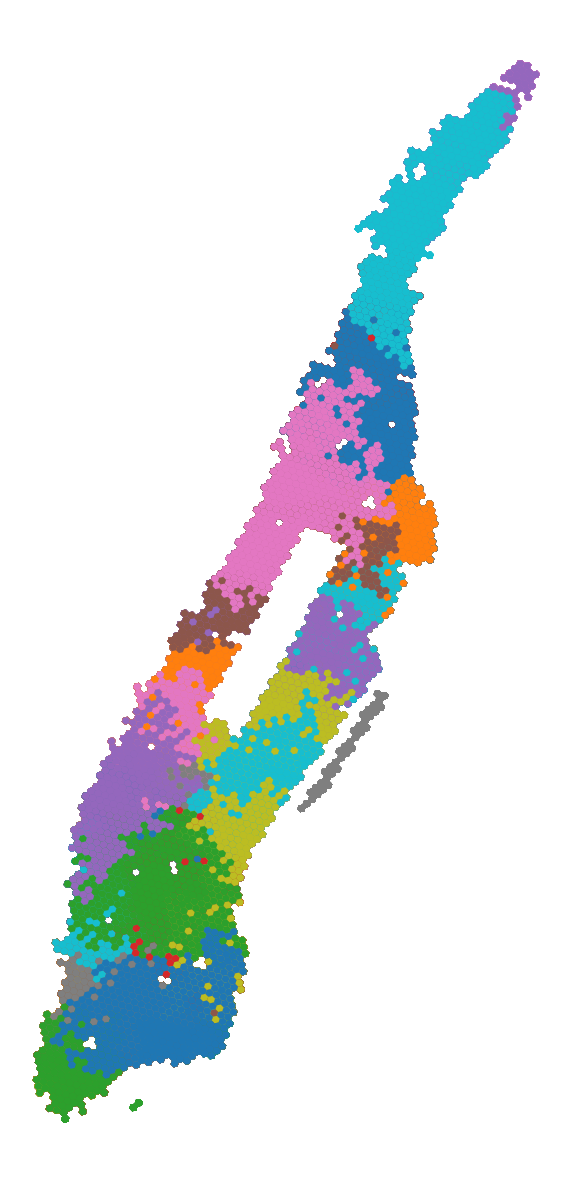

In [497]:
df_plot = df.h3.h3_to_geo_boundary()

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(10, 40))
# Plot unique values choropleth including a legend and with no boundary lines
df_plot.plot(column='name', categorical=True, legend=False, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()